In [28]:
import pandas as pd
df = pd.read_csv('final_data.csv')


/var/folders/pc/j_zmpc9s0g9frv2jzfv1l51c0000gn/T/ipykernel_68365/1581852751.py:2: DtypeWarning: Columns (8,16,17,18,24,25,26,27,28,41,42,43,44,45,46,47,48,52,54,55,56,62,65,70,71,73,75,76,77,79,81,82,83,90,96,100,104,105,106,113,115,117,120,121,122,123,124,125,127,136,137,139,141,143,146,147,150,151,154,156,159,160,168,169,173,174,176,177) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_data.csv')


In [29]:
print(len(df))

4270


In [3]:
import os

directory = '/Users/joshstrupp/Documents/Working/Educational/MSDV/ms1-final/archive/cropped_images'
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
print(file_count)

18047


In [4]:
distinct_counts = df.apply(lambda col: col.nunique(), axis=0)
distinct_counts_with_col_names = pd.DataFrame({'Column': df.columns, 'Distinct Count': distinct_counts})
# print(distinct_counts_with_col_names)

df_counting = distinct_counts_with_col_names.rename(columns={'Column': 'Column', 'Distinct Count': 'Distinct Count'})
df_counting['Non-Null Count'] = df.notnull().sum().values
# print(df_counting)

In [5]:
#create new df called "df_clean_1" that drops columns where non-null count is less than 100
df_clean_1 = df.dropna(axis=1, thresh=25)
# df_clean_1 = df_clean_1.drop(columns=['Location'])
print(df_clean_1)

          Name            Bounding Box    Area  Confidence  \
0       sleeve    [516, 121, 691, 540]   73325    0.978164   
1       sleeve     [88, 134, 264, 534]   70400    0.989807   
2       sleeve    [488, 176, 595, 440]   28248    0.979248   
3       sleeve    [223, 141, 310, 478]   29319    0.947875   
4         shoe  [291, 1416, 397, 1567]   16006    0.989147   
...        ...                     ...     ...         ...   
4265      shoe    [272, 848, 317, 926]    3510    0.922755   
4266  neckline    [197, 136, 275, 164]    2184    0.926972   
4267  neckline    [153, 309, 327, 362]    9222    0.946098   
4268     dress     [-3, 304, 444, 887]  260601    0.923287   
4269  neckline    [195, 180, 293, 227]    4606    0.987766   

                                     cropped_image_path  Image_Index  \
0          archive/cropped_images/image_10_sleeve_0.jpg           10   
1          archive/cropped_images/image_10_sleeve_1.jpg           10   
2          archive/cropped_images/image

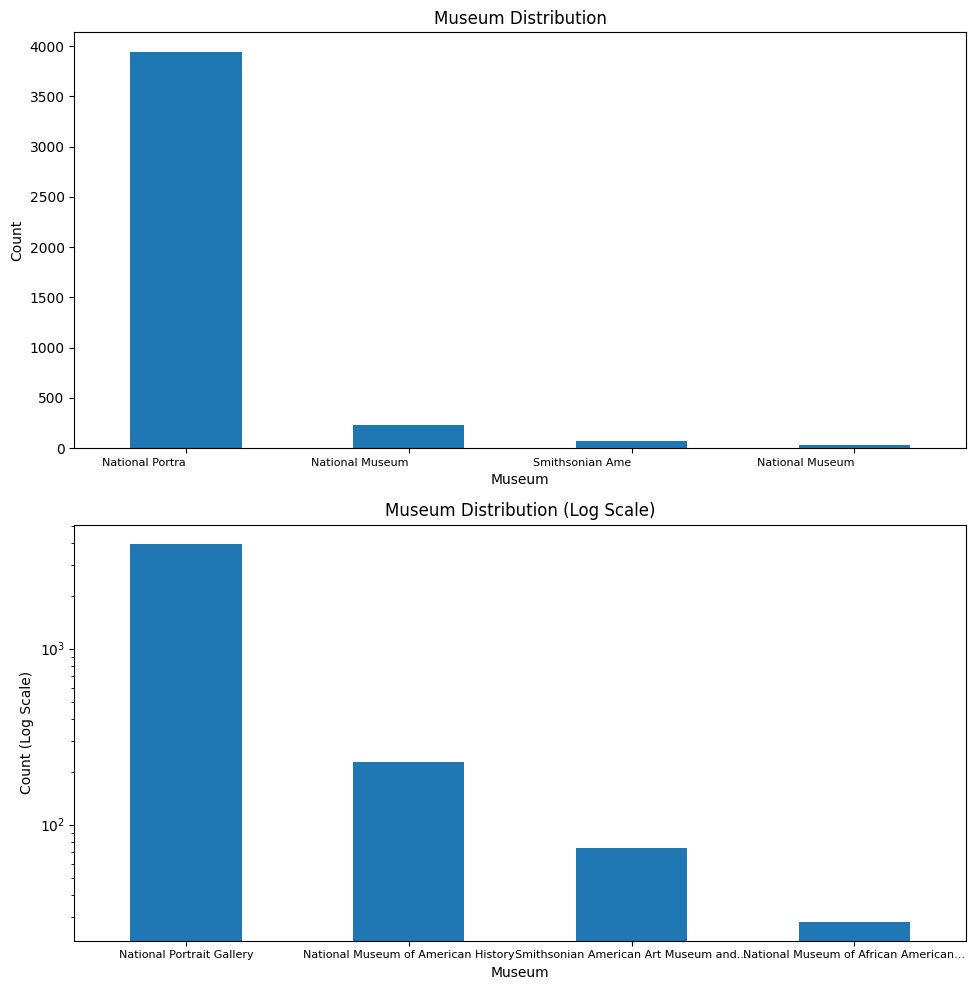

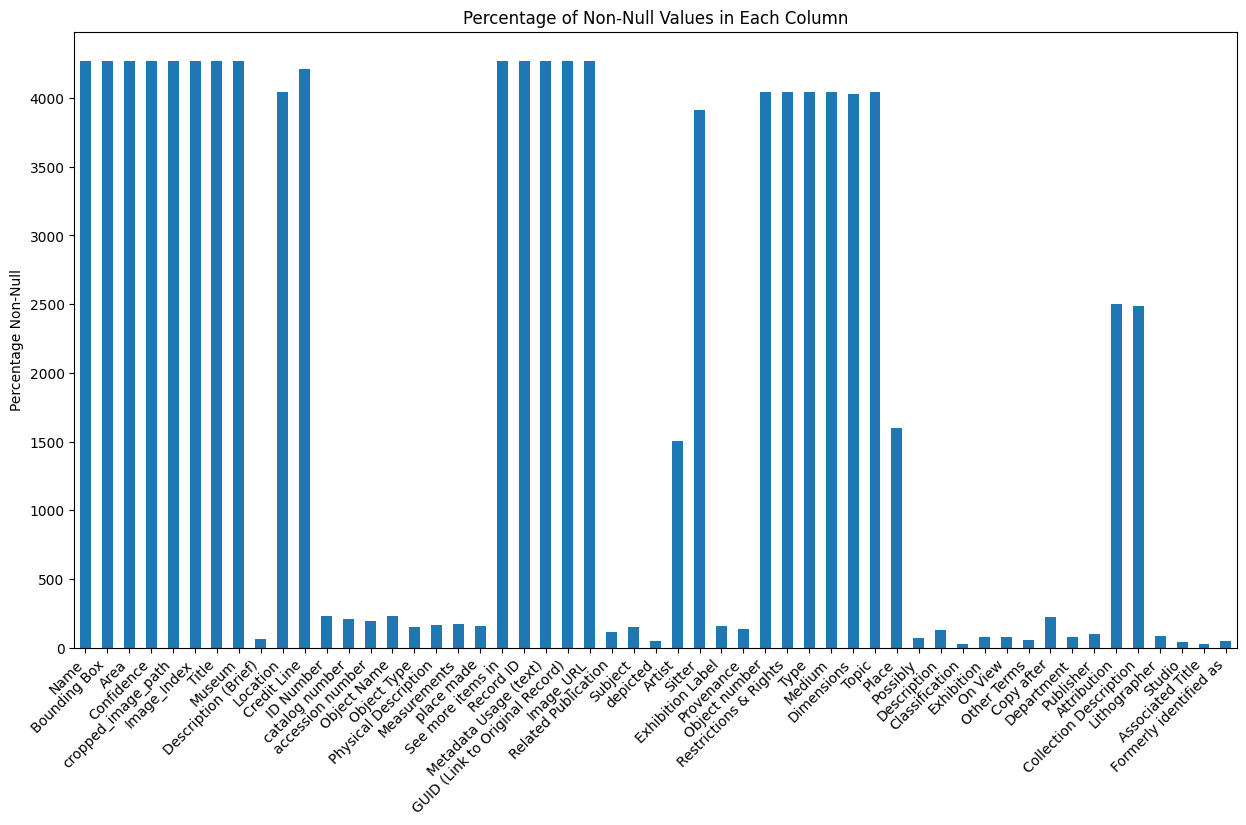

In [6]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Calculate museum distribution
museum_distribution = df_clean_1['Museum'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Bar chart of Museum distribution without log scale
museum_distribution.plot(kind='bar', ax=axes[0])
axes[0].set_title('Museum Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([label[:15] for label in museum_distribution.index], rotation=0, ha='right', fontsize=8)

# Bar chart of Museum distribution on a log scale
museum_distribution.plot(kind='bar', logy=True, ax=axes[1])
axes[1].set_title('Museum Distribution (Log Scale)')
axes[1].set_ylabel('Count (Log Scale)')
axes[1].set_xticklabels([label[:35] + '...' if len(label) > 35 else label for label in museum_distribution.index], rotation=0, ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# plot each column name and percentage non-null
df_clean_1.count().plot(kind='bar')
plt.title('Percentage of Non-Null Values in Each Column')
plt.ylabel('Percentage Non-Null')
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(15, 8)  # Widen the figure to fit all x-axis labels
plt.show()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joshstrupp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joshstrupp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Total rows: 4270
Rows with known 'combined_medium_text': 4270
Rows with 'Unknown' 'combined_medium_text': 0
Embeddings shape: (4270, 384)
Cluster Keywords: {0: 'plate', 5: 'paper', 2: 'silver', 1: 'lithograph', 4: 'gelatin', 6: 'metal', 3: 'canvas', 7: 'ink'}


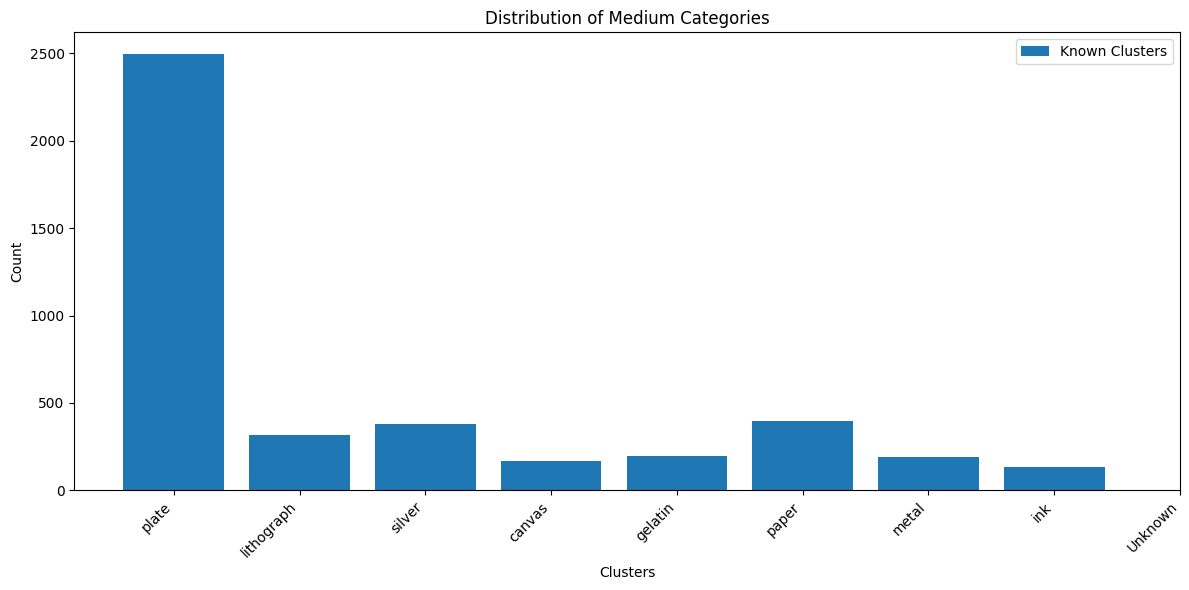

In [19]:
# !pip install sentence_transformers
# !pip install scikit-learn
# !pip install nltk

import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

# Ensure NLTK data is downloaded
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Load your DataFrame
df_material_cater = df_clean_1.copy()

# Combine relevant columns into a single string
columns = ['Object Type', 'Object Name', 'Physical Description', 'Medium']
existing_columns = [col for col in columns if col in df_material_cater.columns]
df_material_cater['combined_medium_text'] = df_material_cater[existing_columns].fillna('').agg(' '.join, axis=1)

# Assign "Unknown" to 'combined_medium_text' where it is empty or contains only whitespace
df_material_cater['combined_medium_text'] = df_material_cater['combined_medium_text'].apply(
    lambda x: x.strip() if x.strip() != '' else 'Unknown'
)

# Identify rows with "Unknown" and separate them
unknown_mask = df_material_cater['combined_medium_text'] == 'Unknown'
df_unknown = df_material_cater[unknown_mask].copy()
df_known = df_material_cater[~unknown_mask].copy()

# Display counts for verification
print(f"Total rows: {df_material_cater.shape[0]}")
print(f"Rows with known 'combined_medium_text': {df_known.shape[0]}")
print(f"Rows with 'Unknown' 'combined_medium_text': {df_unknown.shape[0]}")

# Proceed with processing only known rows for embeddings and clustering
if not df_known.empty:
    # Load the sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings for the combined text
    embeddings = model.encode(df_known['combined_medium_text'].tolist(), convert_to_numpy=True)

    print(f"Embeddings shape: {embeddings.shape}")

    # Cluster the embeddings into 8 clusters
    num_clusters = 8
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
    kmeans.fit(embeddings)
    df_known['medium_cat'] = kmeans.labels_

    def get_top_keywords(data, clusters, n_terms):
        excluded_words = {
        'overall', 
        'fashion',
        'daguerreotype',
        'material',
        # Add more words as needed
    }
        def is_noun(word):
            synsets = wn.synsets(word)
            return any(ss.pos() == 'n' for ss in synsets)
            
        df = pd.DataFrame({'text': data, 'cluster': clusters})
        terms = {}
        used_keywords = set()
        
        # Sort clusters by size to prioritize larger clusters
        cluster_sizes = df['cluster'].value_counts().sort_values(ascending=False)
        
        for cluster in cluster_sizes.index:
            texts = df[df['cluster'] == cluster]['text'].tolist()
            if texts:
                vectorizer = TfidfVectorizer(stop_words='english')
                tfidf = vectorizer.fit_transform(texts)
                mean_tfidf = tfidf.mean(axis=0).A1
                indices = mean_tfidf.argsort()[::-1]
                feature_names = vectorizer.get_feature_names_out()
                
                # Get all nouns sorted by TF-IDF score, excluding already used keywords
                nouns = []
                for i in indices:
                    word = feature_names[i]
                    if (is_noun(word) and 
                        word not in ENGLISH_STOP_WORDS and 
                        word not in used_keywords and 
                        word.lower() not in excluded_words):
                        nouns.append(word)
                    if len(nouns) >= n_terms:
                        break
                
                if nouns:
                    selected_keyword = nouns[0]
                    used_keywords.add(selected_keyword)
                    terms[cluster] = selected_keyword
                else:
                    terms[cluster] = f'Category_{cluster}'
            else:
                terms[cluster] = f'Category_{cluster}'
                
        return terms

    # Get the top keywords for each cluster
    cluster_keywords = get_top_keywords(df_known['combined_medium_text'], kmeans.labels_, 1)
    print("Cluster Keywords:", cluster_keywords)

    # Map cluster labels to category names
    df_known['medium'] = df_known['medium_cat'].map(cluster_keywords)
else:
    print("No known 'combined_medium_text' to process for clustering.")

# Assign "Unknown" to 'medium_cat' and 'medium' for unknown rows
df_unknown['medium_cat'] = 'Unknown'
df_unknown['medium'] = 'Unknown'

# Combine known and unknown DataFrames
df_material_cater = pd.concat([df_known, df_unknown], ignore_index=True)

# Save the updated DataFrame
df_material_cater.to_csv('your_data_with_categories.csv', index=False)

# Create a bar plot of cluster counts, including "Unknown"
plt.figure(figsize=(12, 6))
cluster_counts = df_material_cater['medium_cat'].value_counts()
# Convert index to string to avoid int/str comparison issues during sorting
cluster_counts.index = cluster_counts.index.astype(str)
cluster_counts = cluster_counts.sort_index()

# Prepare labels, ensuring "Unknown" is included
labels = [cluster_keywords.get(i, 'Unknown') for i in range(num_clusters)]
labels.append('Unknown')  # Append 'Unknown' category

# Extract counts for known clusters
known_counts = cluster_counts.iloc[:num_clusters] if cluster_counts.shape[0] >= num_clusters else cluster_counts

# Count 'Unknown' separately
unknown_count = cluster_counts.get('Unknown', 0)

# Plot known clusters
plt.bar(range(len(known_counts)), known_counts.values, label='Known Clusters')

# Plot 'Unknown' cluster if exists
if unknown_count > 0:
    plt.bar(len(known_counts), unknown_count, label='Unknown')

# Create xticks with labels
plt.xticks(
    range(len(labels)), # Use length of labels directly to ensure matching lengths
    labels,
    rotation=45,
    ha='right'
)

plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Distribution of Medium Categories')

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

Embeddings shape: (4270, 384)
{0: 'undefined', 1: 'adornment', 2: 'flowers', 3: 'presidents', 4: 'symbols', 5: 'costume', 6: 'ladies', 7: 'furnishings'}


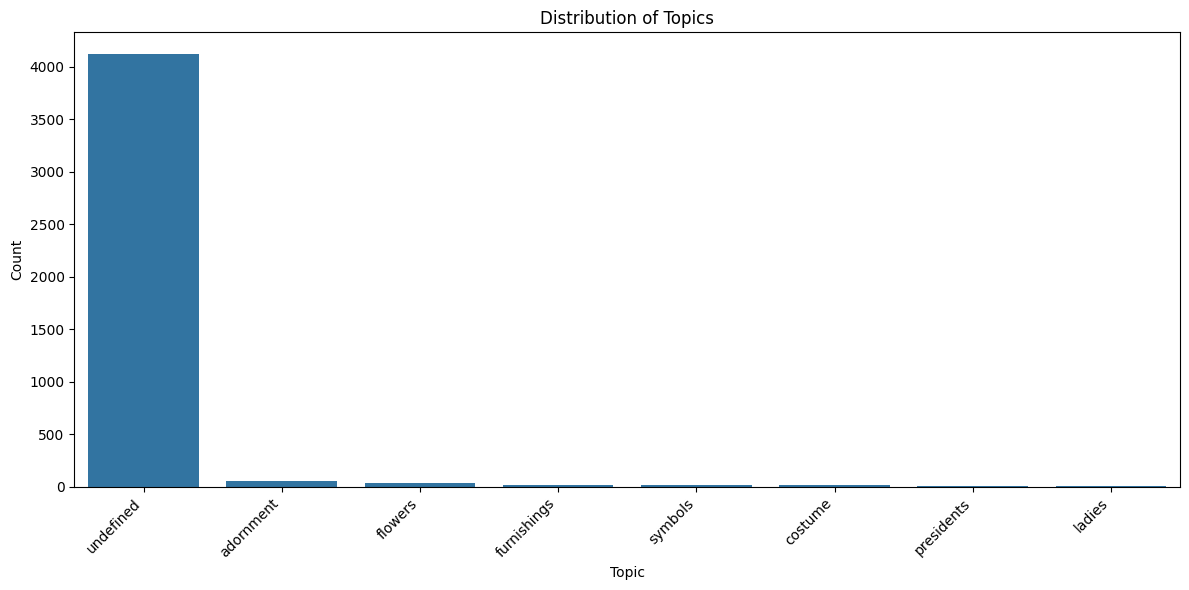

In [27]:
import nltk


import string
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Combine relevant columns into a single string
# Check if the columns exist in the DataFrame
# columns = ['Description (Brief)', 'Physical Description', 'Object Name', 'Type', 'Medium', 'Description']
columns = ['Subject', 'Description.MISC', 'Topic', 'Description']
existing_columns = [col for col in columns if col in df_material_cater.columns]
df_material_cater['combined_topic_text'] = df_material_cater[existing_columns].fillna('').agg(' '.join, axis=1)


# # Drop rows where 'combined_topic_text' is empty or only whitespace
# df_material_cater = df_material_cater[df_material_cater['combined_topic_text'].str.strip() != '']


# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the combined text
embeddings = model.encode(df_material_cater['combined_topic_text'].tolist(), convert_to_numpy=True)

print(f"Embeddings shape: {embeddings.shape}")

# Cluster the embeddings into 8 clusters
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(embeddings)
df_material_cater['topic_cat'] = kmeans.labels_

exclusion_words = [
    'chronology',
    'americans',
    # Add more words as needed
]

# Make sure all exclusion words are in lowercase
exclusion_words = set(word.lower() for word in exclusion_words)

# Function to extract top keywords for each cluster, only including nouns
def get_top_keywords(data, clusters, n_terms=1):
    df = pd.DataFrame({'text': data, 'cluster': clusters})
    terms = {}
    num_clusters = df['cluster'].nunique()
    
    for cluster in range(num_clusters):
        texts = df[df['cluster'] == cluster]['text'].tolist()
        if texts:
            # Process texts to include only nouns
            processed_texts = []
            for text in texts:
                tokens = nltk.word_tokenize(text)
                pos_tags = nltk.pos_tag(tokens)
                nouns = [word for word, pos in pos_tags if pos.startswith('NN') and word.lower() not in exclusion_words]
                processed_text = ' '.join(nouns)
                processed_texts.append(processed_text)
            
            vectorizer = TfidfVectorizer(stop_words='english')
            try:
                tfidf = vectorizer.fit_transform(processed_texts)
                if tfidf.shape[1] == 0:
                    terms[cluster] = 'undefined'
                    continue
                mean_tfidf = tfidf.mean(axis=0).A1
                indices = mean_tfidf.argsort()[::-1]
                feature_names = vectorizer.get_feature_names_out()
                top_word = next((feature_names[i] for i in indices if feature_names[i].lower() not in exclusion_words and feature_names[i] not in terms.values()), 'undefined')
                terms[cluster] = top_word
            except ValueError:
                # Handle empty vocabulary
                terms[cluster] = 'undefined'
        else:
            terms[cluster] = 'undefined'
    
    return terms

# Get the top keywords for each cluster
cluster_keywords = get_top_keywords(df_material_cater['combined_medium_text'], kmeans.labels_, 1)
# print(cluster_keywords)

# # Map cluster labels to category names
# df_material_cater['medium'] = df_material_cater['medium_cat'].map(cluster_keywords)

# Add new category "topic"
columns_for_topics = ['Subject', 'Description.MISC']
existing_columns_for_topics = [col for col in columns_for_topics if col in df_material_cater.columns]
df_material_cater['combined_topic_text'] = df_material_cater[existing_columns_for_topics].fillna('').agg(' '.join, axis=1)

# Generate embeddings for the combined topic text
topic_embeddings = model.encode(df_material_cater['combined_topic_text'].tolist(), convert_to_numpy=True)

# Adjust the number of clusters if necessary
num_clusters = 8  # You can change this number based on your data
kmeans_topics = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans_topics.fit(topic_embeddings)
df_material_cater['topic_cat'] = kmeans_topics.labels_

# Get the top keywords for each topic cluster
topic_keywords = get_top_keywords(df_material_cater['combined_topic_text'], kmeans_topics.labels_, 1)
print(topic_keywords)

# Map topic cluster labels to category names
df_material_cater['topic'] = df_material_cater['topic_cat'].map(topic_keywords)

# Save the updated DataFrame
df_material_topic_cater = df_material_cater.copy()
df_material_topic_cater.to_csv('your_data_with_categories_and_topics.csv', index=False)

# !pip install seaborn

import seaborn as sns

# Plot distribution of topics
plt.figure(figsize=(12, 6))
topic_counts = df_material_topic_cater['topic'].value_counts()
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [26]:
# Display first 5 rows of the relevant columns
print("Sample Data:")
print(df_material_cater[existing_columns].head())

Sample Data:
  Subject                                              Topic  \
0     NaN  ['African American', 'Clothing and dress', 'Co...   
1     NaN  ['African American', 'Clothing and dress', 'Co...   
2     NaN  ['African American', 'Actors', 'Blaxploitation...   
3     NaN  ['African American', 'Actors', 'Blaxploitation...   
4     NaN  ['African American', 'Clothing and dress', 'Co...   

                                         Description  
0  ['This blue jacket (.1) and Hammer pants (.2) ...  
1  ['This blue jacket (.1) and Hammer pants (.2) ...  
2  ['This cream fur coat was worn by Max Julien a...  
3  ['This cream fur coat was worn by Max Julien a...  
4  ['A pair of black boots from an S1W uniform. T...  


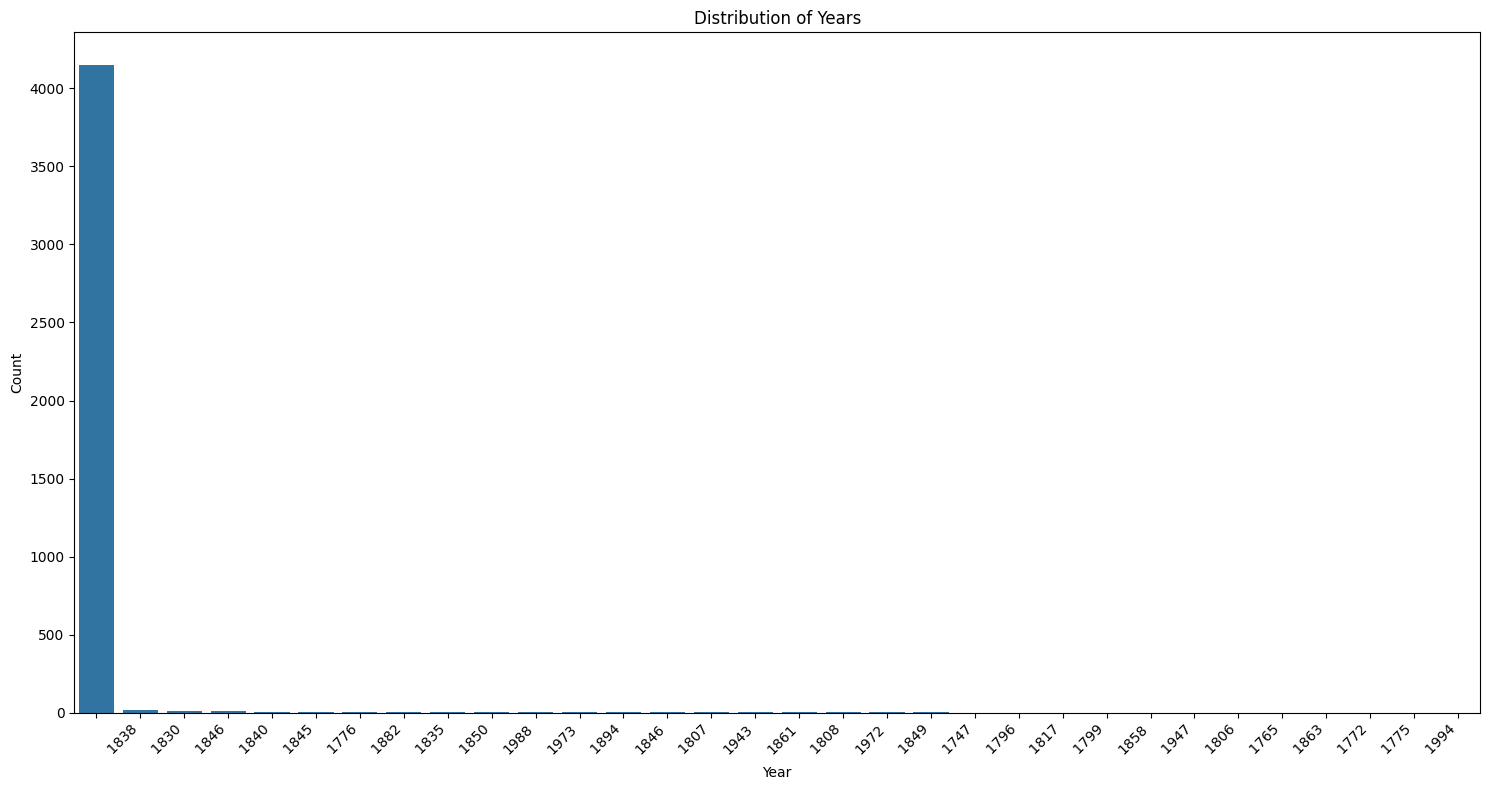

In [9]:
import re 
df_material_topic_year_cater = df_material_topic_cater.copy()

# add a new empty column called 'year'
df_material_topic_year_cater['all_years'] = ''

# using regex, extract years — by finding 4-digit numbers surrounded by spaces — from the following columns and print them here:
# Description (Brief)', 'Artist', 'Sitter', 'Worn by', 'Description'

# Define the regex pattern
pattern = re.compile(r'\b\d{4}\b')

# Define the columns to search
columns = ['Description', 'Description (Brief)']

# iterate through cells in columns and extract all years, and place them in the "year" column separated by commas. Ensure that if there is more than 1 year in a cell or string, they are separated by commas.
for index, row in df_material_topic_year_cater.iterrows():
    years = []
    for column in columns:
        if pd.notnull(row[column]):
            years.extend(pattern.findall(row[column]))
    df_material_topic_year_cater.at[index, 'all_years'] = ', '.join(years)

# create new column called 'est_year' that contains the earliest year from the 'all_years' column
df_material_topic_year_cater['est_year'] = df_material_topic_year_cater['all_years'].str.split(',').apply(lambda x: min(x, default=''))

# Plot distribution of years
plt.figure(figsize=(15, 8))
year_counts = df_material_topic_year_cater['est_year'].value_counts()
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Years')
plt.xlabel('Year') 
plt.ylabel('Count')
plt.tight_layout()
plt.show()



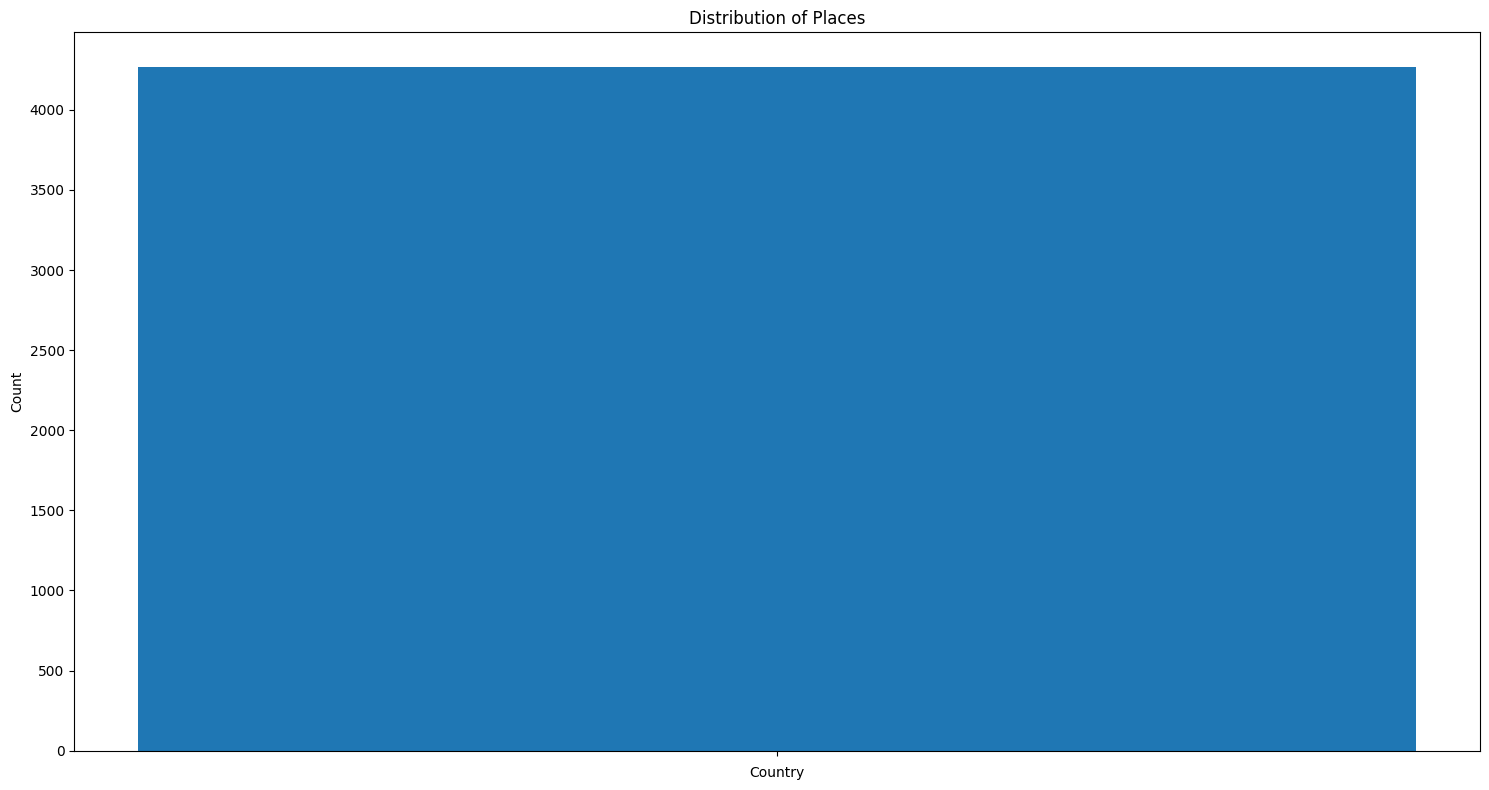

In [10]:
# make copy of df_material_topic_year_cater and make it equal to a new df called df_material_topic_year_place_cater
df_material_topic_year_place_cater = df_material_topic_year_cater.copy()

# add new column to df_material_topic_year_place_cater called 'all_places' and set it to empty string
df_material_topic_year_place_cater['all_places'] = ''

# for any column that includes ".LOC" in its column name, extract all text and place it in the 'all_places' column separated by commas
columns = [col for col in df_material_topic_year_place_cater.columns if '.LOC' in col]
for index, row in df_material_topic_year_place_cater.iterrows():
    places = []
    for column in columns:
        if pd.notnull(row[column]):
            places.append(row[column])
    df_material_topic_year_place_cater.at[index, 'all_places'] = ', '.join(places)

# create new empty column called est_place
df_material_topic_year_place_cater['est_place'] = ''

import pycountry


# using pycountry, extract the country name from the 'all_places' column and place it in the 'est_place' column
def extract_country_name(place):
    for country in pycountry.countries:
        if country.name.lower() in place.lower() and country.name.lower() != 'jersey':
            return country.name
    return ''

df_material_topic_year_place_cater['est_place'] = df_material_topic_year_place_cater['all_places'].apply(extract_country_name)

# Plot distribution of places
plt.figure(figsize=(15, 8))
place_counts = df_material_topic_year_place_cater['est_place'].value_counts()
plt.bar(place_counts.index, place_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Places')
plt.xlabel('Country')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [11]:
# export df_material_topic_year_place_cater to csv
df_material_topic_year_place_cater.to_csv('final_data_cat.csv', index=False)

